In [1]:
import math
import numpy as np
import torch
from torch import nn
import os
from torch.utils import data
from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]
]
features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.9179],
         [-0.7629]]),
 tensor([[ 1.0000e+00,  1.9179e+00,  1.8392e+00,  1.1758e+00,  5.6376e-01,
           2.1625e-01,  6.9123e-02,  1.8939e-02,  4.5403e-03,  9.6755e-04,
           1.8557e-04,  3.2354e-05,  5.1710e-06,  7.6289e-07,  1.0451e-07,
           1.3363e-08,  1.6018e-09,  1.8071e-10,  1.9254e-11,  1.9436e-12],
         [ 1.0000e+00, -7.6290e-01,  2.9101e-01, -7.4002e-02,  1.4114e-02,
          -2.1535e-03,  2.7382e-04, -2.9842e-05,  2.8458e-06, -2.4123e-07,
           1.8403e-08, -1.2763e-09,  8.1143e-11, -4.7618e-12,  2.5948e-13,
          -1.3197e-14,  6.2926e-16, -2.8239e-17,  1.1969e-18, -4.8057e-20]]),
 tensor([7.7451, 2.5767]))

In [4]:
def evaluate_loss(net, data_iter, loss):
    metric = Accumulator(2)
    for x, y in data_iter:
        out = net(x)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels, 
         num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = load_array((train_features, train_labels.reshape(-1, 1)), 
                            batch_size)
    test_iter = load_array((test_features, test_labels.reshape(-1, 1)), 
                          batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = Animator(xlabel='epoch', ylabel='loss', yscale='log', 
                       xlim=[1, num_epochs], ylim=[1e-3, 1e2], 
                       legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

In [6]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: set_axes(self.axes[
                                                0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def use_svg_display():
    display.set_matplotlib_formats('svg')

def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)

weight: [[ 4.9955163  1.2217635 -3.402859   5.5606303]]


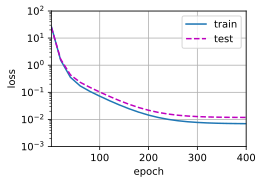

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], 
     labels[:n_train], labels[n_train:])

weight: [[3.102667  3.7404244]]


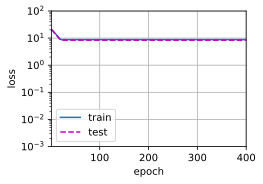

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], 
     labels[:n_train], labels[n_train:])

weight: [[ 4.966118    1.2831806  -3.2703643   5.1604595  -0.32238674  1.3596547
  -0.01628581 -0.06531809  0.06356811  0.11184494 -0.20854934 -0.09894856
   0.15752257 -0.17767736  0.18776385 -0.20463265 -0.19033213 -0.04275765
  -0.11342454 -0.20192619]]


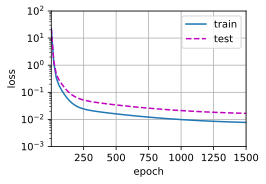

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :], 
     labels[:n_train], labels[n_train:], num_epochs=1500)